Dave Brunner
Group G27

In [205]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Binary Classification

Here, we use a tabular dataset from kaggle (https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset) with features on patients physical spine details possibly suited for classifying whether the person is 'abnormal' or 'normal' - possibly suffers back pain or not.   

We here just want to see how the training works with logistic regression (binary case). We set aside a proper handling of the learning experiment by splitting the data into a train and test partition (in general we would even have a validation partition). We focus here on making the system learn something. 

1. Download the dataset from kaggle (see the link in the notebook). Load it into a pandas dataframe (see the code in the notebook). Normalise the data.
2. Complete the code for the implementation of the methods \verb|predict|, \verb|cost|, \verb|gradient_cost|, \verb|accuracy|. As a test, just invoke the method by suitable dummy values.
3. Implement (full) batch GD for minimizing the CE cost (without autograd). Plot cost vs the number of epochs.
4. Implement (full) batch GD for minimizing the CE cost, this time with autograd. show that you obtain consistent results.
5. Tune the learning rate. What is a reasonable learning rate?

### 1. Load Data

In [206]:
import pandas as pd
df = pd.read_csv("./data/Dataset_spine.csv") # possibly modify!
df = df.drop(columns=['Unnamed: 13'])
N  = df.shape[0]
shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,31.484218,7.826221,24.284818,23.657997,113.833145,4.393080,0.713153,9.7107,8.1003,11.85555,-26.650369,12.6599,Abnormal
1,68.613001,15.082235,63.014696,53.530766,123.431174,39.497987,0.249351,27.0646,17.7171,7.18220,-20.883262,17.1130,Abnormal
2,67.412538,17.442797,60.144640,49.969741,111.123970,33.157646,0.855643,18.9972,12.8779,11.82259,-14.550070,42.2698,Abnormal
3,86.900794,32.928168,47.794347,53.972627,135.075364,101.719092,0.459674,25.0986,8.7655,8.93510,-21.318960,12.8518,Abnormal
4,56.563824,8.961262,52.577846,47.602562,98.777115,50.701873,0.588948,18.1451,13.9634,12.46567,0.744240,32.4471,Abnormal


#### Normalization and Turning into Torch Tensors

In [207]:
x0 = torch.from_numpy(shuffled_df.values[:,0:-1].astype(np.float64))
X = (x0-torch.mean(x0, dim=0))/torch.std(x0,dim=0)
Y = torch.tensor(('Abnormal'==shuffled_df.values[:,-1])).int().reshape(-1,1)
print(X.shape, Y.shape)

print(X[:1,:])
print(Y[:1,:])

torch.Size([310, 12]) torch.Size([310, 1])
tensor([[-1.6832, -0.9709, -1.4900, -1.4375, -0.3069, -0.5832,  0.8404, -1.3439,
         -1.4602, -0.0269, -1.0304, -1.2426]], dtype=torch.float64)
tensor([[1]], dtype=torch.int32)


### 2. Implement the Model for (Binary) Logistic Regression

Data:  $\,\qquad X = \left(\begin{array}{cccc} 1 & X_{11} & \dots & X_{1n} \\ \vdots & \vdots & \vdots & \vdots \\ 1 & X_{N1} & \dots & X_{Nn}\end{array}\right)\qquad$ and $\qquad Y = \left(\begin{array}{c} Y_{1} \\ \vdots \\ Y_{N} \end{array}\right)$

Model: $\qquad\hat{Y}(X;W) = \sigma\left(X W^\intercal\right) \qquad$ where $\qquad W = \left(\begin{array}{c} W_0 \\ W_1 \\ \vdots \\ W_n \end{array}\right)$

The model outputs the probability of observing in a sample $x$ a '1' (Abnormal).

Cost:  $\,\qquad C(W) = -\frac{1}{N}\sum_j \left(Y_j\log(\hat{Y}_j(X;W)) + (1-Y_j)\log(1-\hat{Y}_j(X;W))\right)$

__Remark:__ Note that the logarithm diverges at arguments approaching 0. Make sure that you don't run into numerical issues.

In [208]:
# compose torch tensors X of shape (N,13) by inserting a column with 1's as first column  
X = torch.cat((torch.ones(N,1),X), dim=1)
X[1,:]

tensor([ 1.0000,  0.4709, -0.2459,  0.5974,  0.7880,  0.4138,  0.3515, -0.7825,
         0.6648,  1.3685, -1.6421, -0.5587, -0.8165], dtype=torch.float64)

In [209]:
# implement methods for predicting the probability of having label 0 or 1 (W with shape (1,13))
def sigmoid(x):
    return 1/(1+ np.exp(-x))

def predict(X,W):
    if X.shape[1] != W.shape[0]:
        raise ValueError("Shape mismatch: X and W must have compatible shapes for matrix multiplication.")
    z = torch.matmul(X, W)
    return sigmoid(z)

def binary_cross_entropy_loss(X,Y,W):
    y_pred = predict(X,W)
    epsilon = 1e-7  # Small value to avoid log(0)
    return -torch.mean(Y * torch.log(y_pred + epsilon) + (1 - Y) * torch.log(1 - y_pred + epsilon))
    

In [210]:
def gradient_cost(X,Y,W):
    y_pred = predict(X,W)
    return torch.matmul(X.t(), y_pred - Y) / len(Y)
        
def accuracy(Y,Yhat):
    flattened_predictions = torch.where(Yhat >= 0.5, torch.tensor(1), torch.tensor(0))
    num_correct = torch.sum(Y == flattened_predictions).item()
    num_samples = Y.numel()
    return num_correct / num_samples

Just for testing:

In [211]:
W = torch.randn((1,13), dtype=torch.double)
# predict(X[0],W)
# binary_cross_entropy_loss(X[0],Y[0],W)

### 3. Implement Full Batch Gradient Descent

Training Accuracy (max,end): 0.864516, 0.858065
Training Cost (end): 0.308150


Text(0, 0.5, 'Accuracy')

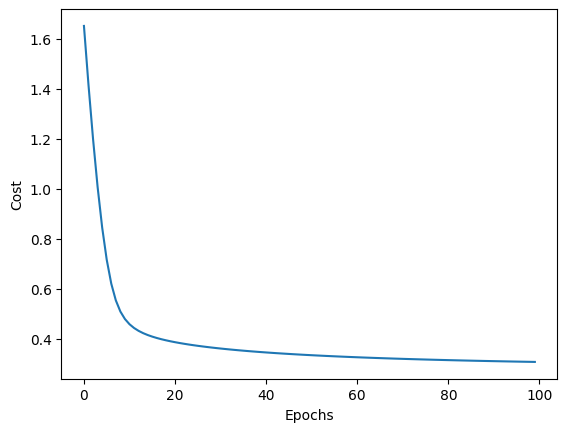

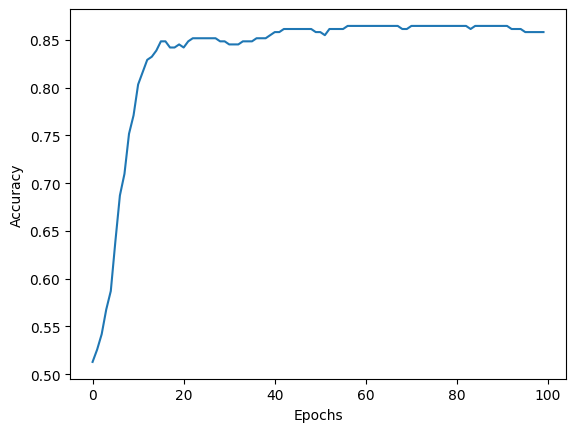

In [212]:
# adjust if needed
n_epochs = 100
learning_rate = 1.0

## initial parameter
W = torch.randn(13,1, dtype=torch.double)

# track the costs
costs = []
accuracies = []
# costs = [cost(X,Y,W)]
# accuracies = [accuracy(Y,predict(X,W))]

for epoch in range(n_epochs):
    W = W - learning_rate * gradient_cost(X,Y,W)
    costs.append(binary_cross_entropy_loss(X,Y,W))
    acc = accuracy(Y,predict(X,W))
    accuracies.append(acc)


# some output
print("Training Accuracy (max,end): %f, %f"%(np.max(accuracies), accuracies[len(accuracies)-1]))
print("Training Cost (end): %f"%costs[-1].item())
plt.figure(1)
plt.plot(range(n_epochs),costs)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.figure(2)
plt.plot(range(n_epochs),accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

### 4. Implement Full Batch Gradient Descent with PyTorch's autograd

Epoch: 0: has loss on test set: 0.584269
Epoch: 1: has loss on test set: 0.579762
Epoch: 2: has loss on test set: 0.575696
Epoch: 3: has loss on test set: 0.572024
Epoch: 4: has loss on test set: 0.568704
Epoch: 5: has loss on test set: 0.565700
Epoch: 6: has loss on test set: 0.562979
Epoch: 7: has loss on test set: 0.560512
Epoch: 8: has loss on test set: 0.558274
Epoch: 9: has loss on test set: 0.556241
Epoch: 10: has loss on test set: 0.554394
Epoch: 11: has loss on test set: 0.552713
Epoch: 12: has loss on test set: 0.551183
Epoch: 13: has loss on test set: 0.549789
Epoch: 14: has loss on test set: 0.548517
Epoch: 15: has loss on test set: 0.547356
Epoch: 16: has loss on test set: 0.546295
Epoch: 17: has loss on test set: 0.545325
Epoch: 18: has loss on test set: 0.544437
Epoch: 19: has loss on test set: 0.543623
Epoch: 20: has loss on test set: 0.542877
Epoch: 21: has loss on test set: 0.542192
Epoch: 22: has loss on test set: 0.541562
Epoch: 23: has loss on test set: 0.540982
Ep

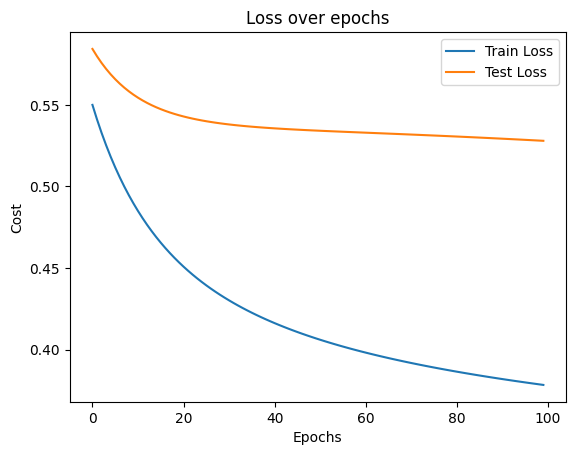

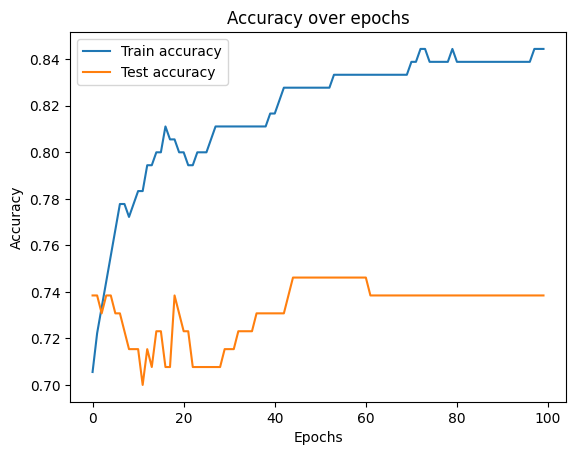

In [224]:
from torch import nn

linear = torch.nn.Linear(2, 1)

class BinaryLogistRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(BinaryLogistRegressionModel, self).__init__()
        self.flatten = nn.Sigmoid()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
       return  self.flatten(self.linear(x))


model = BinaryLogistRegressionModel(13, 1)

epochs = 100
learning_rate=0.1
cost = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


X_train = X[:180,:].float()
Y_train = Y[:180,:].float()

X_test = X[180:,:].float()
Y_test = Y[180:,:].float()

loss_list_on_train = []
loss_list_on_test = []
accuracy_list_test = []
accuracy_list_train = []

for epoch in range(epochs):
    pred = model(X_train)
    loss = cost(pred, Y_train)
    predicted_labels = (pred > 0.5).float()
    accuracy = (predicted_labels == Y_train.float()).float().mean().item()
    accuracy_list_train.append(accuracy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ce_loss = loss.squeeze().item()
    loss_list_on_train.append(ce_loss)
    
    # print("Epoch: %i: has loss on train set: %f" %(epoch, ce_loss))
    with torch.no_grad():
        pred = model(X_test)
        ce_loss_on_test = cost(pred, Y_test).squeeze().item()
        loss_list_on_test.append(ce_loss_on_test)
        predicted_labels = (pred > 0.5).float()
        accuracy = (predicted_labels == Y_test.float()).float().mean().item()
        accuracy_list_test.append(accuracy)
    print("Epoch: %i: has loss on test set: %f" %(epoch, ce_loss_on_test))
    
    
plt.plot(range(epochs), loss_list_on_train, label="Train Loss")
plt.plot(range(epochs), loss_list_on_test, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Loss over epochs")
plt.legend()

plt.figure(2)
plt.plot(range(epochs), accuracy_list_train, label="Train accuracy")
plt.plot(range(epochs), accuracy_list_test, label="Test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.legend()

print("Final cost: ", ce_loss)

### 5. Tune Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.